# Enable Agent Tutorial Part 3: 예측 결과 컨텍스트화

## 개요

Enable Agent의 예측 결과를 저장하고 지식 베이스로 변환한다.

## Context Builder의 역할

```
+------------------+
|  Enable Agent    |
|   예측 수행      |
+--------+---------+
         | prediction_result
         v
+------------------------------+
|  PredictionContextBuilder    |
+------------------------------+
| 1. 예측 로그 저장            |
| 2. 통계 요약 생성            |
| 3. 자연어 지식 베이스 구축   |
+--------+---------------------+
         |
         +-> prediction_logs.json
         +-> prediction_summary.json
         +-> knowledge_base.txt
```

## 학습 내용

- 예측 결과 저장 및 관리
- 통계 요약 자동 생성
- 자연어 지식 베이스 구축
- RAG를 위한 컨텍스트 준비

---
## 1. 라이브러리 임포트

In [1]:
import json
import os
import yaml
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import List, Dict, Any, Tuple
from pathlib import Path
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
plt.rcParams['font.family'] = 'DejaVu Sans'
print("라이브러리 임포트 완료")

라이브러리 임포트 완료


---
## 2. PredictionContextBuilder 클래스 구현

### 주요 기능

- `add_prediction()`: 새로운 예측 결과 추가
- `_update_summary()`: 통계 요약 자동 갱신
- `_update_knowledge_base()`: 자연어 지식 베이스 갱신
- `get_summary()`: 요약 정보 조회
- `get_knowledge_base_content()`: 지식 베이스 조회

In [2]:
class PredictionContextBuilder:
    """예측 결과를 컨텍스트로 저장하고 관리하는 클래스"""
    
    def __init__(self, context_dir: str = 'context_store'):
        """Context Builder 초기화"""
        self.context_dir = Path(context_dir)
        self.context_dir.mkdir(exist_ok=True)
        
        self.log_file = self.context_dir / 'prediction_logs.json'
        self.summary_file = self.context_dir / 'prediction_summary.json'
        self.knowledge_base_file = self.context_dir / 'knowledge_base.txt'
        
        self.logs = self._load_logs()
        
        print(f"Context Builder 초기화 완료")
        print(f"저장된 예측 로그: {len(self.logs)}개")
    
    def _load_logs(self) -> List[Dict[str, Any]]:
        """기존 로그를 로드한다"""
        if self.log_file.exists():
            with open(self.log_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return []
    
    def add_prediction(self, prediction_result: Dict[str, Any]):
        """새로운 예측 결과를 컨텍스트에 추가한다"""
        self.logs.append(prediction_result)
        
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.logs, f, indent=2, ensure_ascii=False)
        
        print(f"예측 결과 저장 완료 (총 {len(self.logs)}개)")
        
        self._update_summary()
        self._update_knowledge_base()
    
    def _update_summary(self):
        """예측 결과 요약을 업데이트한다"""
        if not self.logs:
            return
        
        total_predictions = len(self.logs)
        
        class_counts = {}
        confidence_sum = 0
        
        for log in self.logs:
            predicted_class = log['predicted_class']
            class_counts[predicted_class] = class_counts.get(predicted_class, 0) + 1
            confidence_sum += log['confidence']
        
        avg_confidence = confidence_sum / total_predictions
        
        feature_stats = {
            'sepal_length': [],
            'sepal_width': [],
            'petal_length': [],
            'petal_width': []
        }
        
        for log in self.logs:
            for feature, value in log['input_features'].items():
                feature_stats[feature].append(value)
        
        feature_averages = {
            feature: sum(values) / len(values)
            for feature, values in feature_stats.items()
        }
        
        summary = {
            "total_predictions": total_predictions,
            "class_distribution": class_counts,
            "average_confidence": avg_confidence,
            "feature_averages": feature_averages,
            "last_updated": datetime.now().isoformat()
        }
        
        with open(self.summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
    
    def _update_knowledge_base(self):
        """예측 결과를 자연어 지식 베이스로 변환한다"""
        if not self.logs:
            return
        
        with open(self.summary_file, 'r', encoding='utf-8') as f:
            summary = json.load(f)
        
        knowledge_text = f"""# Iris 분류 모델 예측 지식 베이스

## 전체 통계 (마지막 업데이트: {summary['last_updated']})

총 예측 수행 횟수: {summary['total_predictions']}회
평균 예측 신뢰도: {summary['average_confidence']:.2%}

## 품종별 예측 분포

"""
        
        for species, count in summary['class_distribution'].items():
            percentage = (count / summary['total_predictions']) * 100
            knowledge_text += f"- {species}: {count}회 ({percentage:.1f}%)\n"
        
        knowledge_text += "\n## 평균 특성 값\n\n"
        
        for feature, avg_value in summary['feature_averages'].items():
            knowledge_text += f"- {feature}: {avg_value:.2f} cm\n"
        
        knowledge_text += "\n## 최근 예측 기록 (최근 10개)\n\n"
        
        recent_logs = self.logs[-10:]
        for i, log in enumerate(reversed(recent_logs), 1):
            timestamp = log['timestamp']
            predicted_class = log['predicted_class']
            confidence = log['confidence']
            
            knowledge_text += f"""### 예측 #{len(self.logs) - i + 1} ({timestamp})

- 예측 품종: {predicted_class}
- 신뢰도: {confidence:.2%}
- 입력 특성:
  * 꽃받침 길이: {log['input_features']['sepal_length']} cm
  * 꽃받침 너비: {log['input_features']['sepal_width']} cm
  * 꽃잎 길이: {log['input_features']['petal_length']} cm
  * 꽃잎 너비: {log['input_features']['petal_width']} cm
- 각 품종별 확률:
"""
            
            for species, prob in log['probabilities'].items():
                knowledge_text += f"  * {species}: {prob:.2%}\n"
            
            knowledge_text += "\n"
        
        with open(self.knowledge_base_file, 'w', encoding='utf-8') as f:
            f.write(knowledge_text.strip())
    
    def get_knowledge_base_content(self) -> str:
        """지식 베이스 내용을 반환한다"""
        if self.knowledge_base_file.exists():
            with open(self.knowledge_base_file, 'r', encoding='utf-8') as f:
                return f.read()
        return ""
    
    def get_summary(self) -> Dict[str, Any]:
        """요약 정보를 반환한다"""
        if self.summary_file.exists():
            with open(self.summary_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return {}
    
    def clear_logs(self):
        """로그를 초기화한다"""
        self.logs = []
        for file in [self.log_file, self.summary_file, self.knowledge_base_file]:
            if file.exists():
                file.unlink()
        print("로그 초기화 완료")

print("PredictionContextBuilder 클래스 정의 완료")

PredictionContextBuilder 클래스 정의 완료


---
## 3. Context Builder 초기화

In [3]:
context_builder = PredictionContextBuilder()

existing_summary = context_builder.get_summary()
if existing_summary:
    print("\n기존 예측 통계:")
    print(json.dumps(existing_summary, indent=2, ensure_ascii=False))
else:
    print("\n새로운 컨텍스트 저장소가 생성되었다.")

Context Builder 초기화 완료
저장된 예측 로그: 0개

새로운 컨텍스트 저장소가 생성되었다.


---
## 4. IrisEnableAgent 클래스 (Part 2에서 재사용)

In [4]:
class IrisEnableAgent:
    """Iris 분류 모델을 Enable Agent로 래핑한 클래스"""
    
    def __init__(self, skill_path: str):
        """Enable Agent 초기화"""
        with open(skill_path, 'r', encoding='utf-8') as f:
            self.skill = yaml.safe_load(f)
        
        model_path = self.skill['model_info']['model_path']
        self.model = joblib.load(model_path)
        
        metadata_path = self.skill['model_info']['metadata_path']
        with open(metadata_path, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)
        
        self.client = OpenAI()
        
        print(f"Enable Agent 초기화 완료: {self.skill['agent_name']}")
        print(f"모델 정확도: {self.metadata['accuracy']:.4f}")
    
    def validate_input(self, input_data: Dict[str, float]) -> Tuple[bool, str]:
        """입력 데이터의 유효성을 검증한다"""
        required_fields = self.skill['input_schema']['required']
        properties = self.skill['input_schema']['properties']
        
        for field in required_fields:
            if field not in input_data:
                return False, f"필수 필드 누락: {field}"
        
        for field, value in input_data.items():
            if field in properties:
                prop = properties[field]
                if 'minimum' in prop and value < prop['minimum']:
                    return False, f"{field}가 최소값({prop['minimum']})보다 작다: {value}"
                if 'maximum' in prop and value > prop['maximum']:
                    return False, f"{field}가 최대값({prop['maximum']})보다 크다: {value}"
        
        return True, "유효한 입력"
    
    def predict(self, input_data: Dict[str, float]) -> Dict[str, Any]:
        """예측을 수행한다"""
        is_valid, message = self.validate_input(input_data)
        if not is_valid:
            raise ValueError(message)
        
        feature_names = self.metadata['feature_names']
        X = np.array([[
            input_data['sepal_length'],
            input_data['sepal_width'],
            input_data['petal_length'],
            input_data['petal_width']
        ]])
        
        prediction = self.model.predict(X)[0]
        probabilities = self.model.predict_proba(X)[0]
        
        target_names = self.metadata['target_names']
        predicted_class = target_names[prediction]
        confidence = float(probabilities[prediction])
        
        feature_importance = dict(zip(
            feature_names,
            self.model.feature_importances_.tolist()
        ))
        
        return {
            "predicted_class": predicted_class,
            "confidence": confidence,
            "probabilities": dict(zip(target_names, probabilities.tolist())),
            "feature_importance": feature_importance,
            "input_features": input_data,
            "timestamp": datetime.now().isoformat()
        }

print("IrisEnableAgent 클래스 정의 완료")

IrisEnableAgent 클래스 정의 완료


---
## 5. 예측 수행 및 컨텍스트 저장

In [5]:
agent = IrisEnableAgent('skills/iris_agent_skill.yaml')
print("Enable Agent 로드 완료")

Enable Agent 초기화 완료: Iris Classification Agent
모델 정확도: 0.9333
Enable Agent 로드 완료


In [6]:
# 기존 로그 초기화 (선택사항)
context_builder.clear_logs()

로그 초기화 완료


In [7]:
test_samples = [
    # Setosa 샘플
    {"sepal_length": 5.1, "sepal_width": 3.5, "petal_length": 1.4, "petal_width": 0.2},
    {"sepal_length": 4.9, "sepal_width": 3.0, "petal_length": 1.4, "petal_width": 0.2},
    {"sepal_length": 5.0, "sepal_width": 3.4, "petal_length": 1.5, "petal_width": 0.2},
    # Versicolor 샘플
    {"sepal_length": 6.4, "sepal_width": 3.2, "petal_length": 4.5, "petal_width": 1.5},
    {"sepal_length": 5.7, "sepal_width": 2.8, "petal_length": 4.1, "petal_width": 1.3},
    {"sepal_length": 6.0, "sepal_width": 2.7, "petal_length": 5.1, "petal_width": 1.6},
    # Virginica 샘플
    {"sepal_length": 6.3, "sepal_width": 3.3, "petal_length": 6.0, "petal_width": 2.5},
    {"sepal_length": 5.8, "sepal_width": 2.7, "petal_length": 5.1, "petal_width": 1.9},
    {"sepal_length": 6.7, "sepal_width": 3.1, "petal_length": 5.6, "petal_width": 2.4},
    {"sepal_length": 6.5, "sepal_width": 3.0, "petal_length": 5.8, "petal_width": 2.2},
]

print("=== 예측 수행 및 컨텍스트 저장 ===")
print()

results = []
for i, sample in enumerate(test_samples, 1):
    print(f"[{i}/{len(test_samples)}] 예측 수행 중...")
    result = agent.predict(sample)
    context_builder.add_prediction(result)
    results.append(result)
    print(f"  -> {result['predicted_class']} (신뢰도: {result['confidence']:.2%})")
    print()

=== 예측 수행 및 컨텍스트 저장 ===

[1/10] 예측 수행 중...
예측 결과 저장 완료 (총 1개)
  -> setosa (신뢰도: 100.00%)

[2/10] 예측 수행 중...
예측 결과 저장 완료 (총 2개)
  -> setosa (신뢰도: 100.00%)

[3/10] 예측 수행 중...
예측 결과 저장 완료 (총 3개)
  -> setosa (신뢰도: 100.00%)

[4/10] 예측 수행 중...
예측 결과 저장 완료 (총 4개)
  -> versicolor (신뢰도: 97.90%)

[5/10] 예측 수행 중...
예측 결과 저장 완료 (총 5개)
  -> versicolor (신뢰도: 100.00%)

[6/10] 예측 수행 중...
예측 결과 저장 완료 (총 6개)
  -> versicolor (신뢰도: 60.02%)

[7/10] 예측 수행 중...
예측 결과 저장 완료 (총 7개)
  -> virginica (신뢰도: 100.00%)

[8/10] 예측 수행 중...
예측 결과 저장 완료 (총 8개)
  -> virginica (신뢰도: 100.00%)

[9/10] 예측 수행 중...
예측 결과 저장 완료 (총 9개)
  -> virginica (신뢰도: 100.00%)

[10/10] 예측 수행 중...
예측 결과 저장 완료 (총 10개)
  -> virginica (신뢰도: 100.00%)



---
## 6. 통계 요약 분석

In [8]:
summary = context_builder.get_summary()

print("=== 예측 통계 요약 ===")
print(json.dumps(summary, indent=2, ensure_ascii=False))

=== 예측 통계 요약 ===
{
  "total_predictions": 10,
  "class_distribution": {
    "setosa": 3,
    "versicolor": 3,
    "virginica": 4
  },
  "average_confidence": 0.9579166666666665,
  "feature_averages": {
    "sepal_length": 5.839999999999999,
    "sepal_width": 3.0700000000000003,
    "petal_length": 4.05,
    "petal_width": 1.4
  },
  "last_updated": "2025-12-16T09:01:22.605057"
}


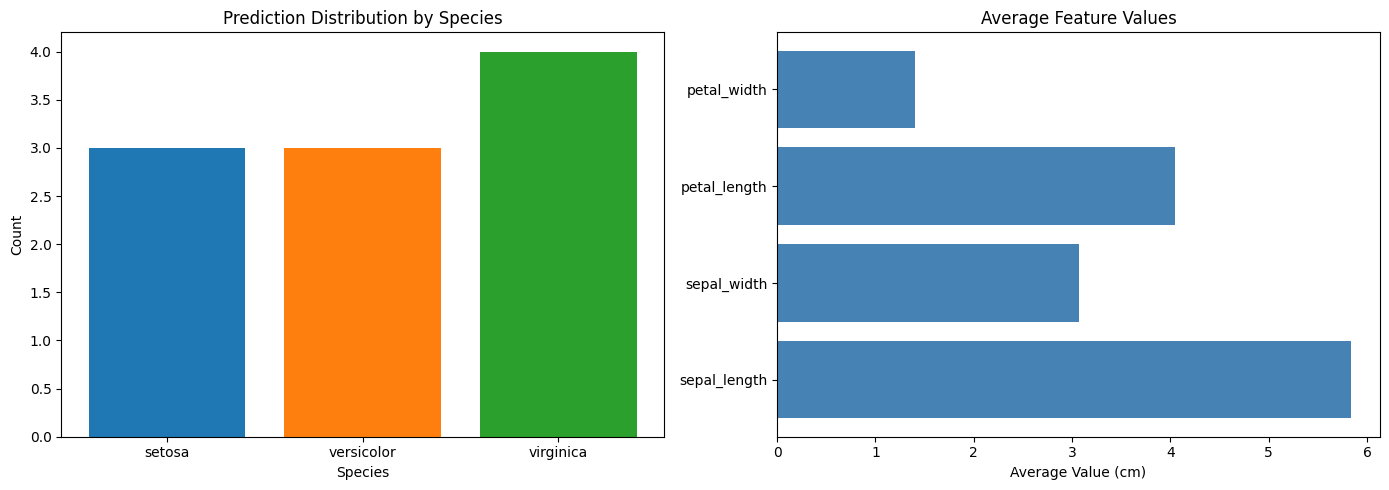

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 품종별 분포
ax1 = axes[0]
species = list(summary['class_distribution'].keys())
counts = list(summary['class_distribution'].values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax1.bar(species, counts, color=colors[:len(species)])
ax1.set_xlabel('Species')
ax1.set_ylabel('Count')
ax1.set_title('Prediction Distribution by Species')

# 평균 특성 값
ax2 = axes[1]
features = list(summary['feature_averages'].keys())
averages = list(summary['feature_averages'].values())
ax2.barh(features, averages, color='steelblue')
ax2.set_xlabel('Average Value (cm)')
ax2.set_title('Average Feature Values')

plt.tight_layout()
plt.show()

---
## 7. 지식 베이스 확인

In [10]:
knowledge_base = context_builder.get_knowledge_base_content()

print("=== 지식 베이스 내용 ===")
print(knowledge_base[:3000])  # 처음 3000자만 출력
print("\n... (이하 생략)")

=== 지식 베이스 내용 ===
# Iris 분류 모델 예측 지식 베이스

## 전체 통계 (마지막 업데이트: 2025-12-16T09:01:22.605057)

총 예측 수행 횟수: 10회
평균 예측 신뢰도: 95.79%

## 품종별 예측 분포

- setosa: 3회 (30.0%)
- versicolor: 3회 (30.0%)
- virginica: 4회 (40.0%)

## 평균 특성 값

- sepal_length: 5.84 cm
- sepal_width: 3.07 cm
- petal_length: 4.05 cm
- petal_width: 1.40 cm

## 최근 예측 기록 (최근 10개)

### 예측 #10 (2025-12-16T09:01:22.604818)

- 예측 품종: virginica
- 신뢰도: 100.00%
- 입력 특성:
  * 꽃받침 길이: 6.5 cm
  * 꽃받침 너비: 3.0 cm
  * 꽃잎 길이: 5.8 cm
  * 꽃잎 너비: 2.2 cm
- 각 품종별 확률:
  * setosa: 0.00%
  * versicolor: 0.00%
  * virginica: 100.00%

### 예측 #9 (2025-12-16T09:01:22.600689)

- 예측 품종: virginica
- 신뢰도: 100.00%
- 입력 특성:
  * 꽃받침 길이: 6.7 cm
  * 꽃받침 너비: 3.1 cm
  * 꽃잎 길이: 5.6 cm
  * 꽃잎 너비: 2.4 cm
- 각 품종별 확률:
  * setosa: 0.00%
  * versicolor: 0.00%
  * virginica: 100.00%

### 예측 #8 (2025-12-16T09:01:22.596321)

- 예측 품종: virginica
- 신뢰도: 100.00%
- 입력 특성:
  * 꽃받침 길이: 5.8 cm
  * 꽃받침 너비: 2.7 cm
  * 꽃잎 길이: 5.1 cm
  * 꽃잎 너비: 1.9 cm
- 각 품종별 확률:
  * setosa: 0.00%
  * ve

---
## 8. 예측 로그 분석

In [11]:
df_logs = pd.DataFrame([
    {
        'timestamp': log['timestamp'],
        'predicted_class': log['predicted_class'],
        'confidence': log['confidence'],
        'sepal_length': log['input_features']['sepal_length'],
        'sepal_width': log['input_features']['sepal_width'],
        'petal_length': log['input_features']['petal_length'],
        'petal_width': log['input_features']['petal_width']
    }
    for log in context_builder.logs
])

print("=== 예측 로그 DataFrame ===")
display(df_logs)

print("\n=== 품종별 통계 ===")
display(df_logs.groupby('predicted_class').agg({
    'confidence': ['mean', 'min', 'max'],
    'predicted_class': 'count'
}).round(4))

=== 예측 로그 DataFrame ===


,timestamp,predicted_class,confidence,sepal_length,sepal_width,petal_length,petal_width
0,2025-12-16T09:01:22.548448,setosa,1.000000,5.1,3.5,1.4,0.2
1,2025-12-16T09:01:22.558412,setosa,1.000000,4.9,3.0,1.4,0.2
2,2025-12-16T09:01:22.568981,setosa,1.000000,5.0,3.4,1.5,0.2
3,2025-12-16T09:01:22.575958,versicolor,0.979000,6.4,3.2,4.5,1.5
4,2025-12-16T09:01:22.581362,versicolor,1.000000,5.7,2.8,4.1,1.3
5,2025-12-16T09:01:22.586694,versicolor,0.600167,6.0,2.7,5.1,1.6
6,2025-12-16T09:01:22.591773,virginica,1.000000,6.3,3.3,6.0,2.5
7,2025-12-16T09:01:22.596321,virginica,1.000000,5.8,2.7,5.1,1.9
8,2025-12-16T09:01:22.600689,virginica,1.000000,6.7,3.1,5.6,2.4
9,2025-12-16T09:01:22.604818,virginica,1.000000,6.5,3.0,5.8,2.2



=== 품종별 통계 ===


confidence              predicted_class
                      mean     min  max           count
predicted_class                                        
setosa              1.0000  1.0000  1.0               3
versicolor          0.8597  0.6002  1.0               3
virginica           1.0000  1.0000  1.0               4